### Zonal means of differences in Alk and Alk_alt

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import pop_tools 
from pint import UnitRegistry
import utils
import ncar_jobqueue
from dask.distributed import Client

units = UnitRegistry()
units.define('micromoles_per_kilogram = umol / kg') # used in WOA datasets

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


#### Define CESM case and get the years of data that we'll average over

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.009'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_alk_alt.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [3]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_PD.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
ds['PD'] = ds_tmp['PD']

In [4]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/mean5thIAF/mean_IAF5_ALK.nc'
ds_tmp = xr.open_dataset(file,decode_times=False,decode_coords=False)
ds['ALK'] = ds_tmp['ALK']

In [5]:
ds

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    TAREA        (nlat, nlon) float64 ...
    REGION_MASK  (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    PD           (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...

In [6]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds.z_t

In [7]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [8]:
#cesm_ann_ds['PD'].isel(z_t=0).plot()

In [9]:
#cesm_ann_ds.ALK_ALT_CO2.isel(z_t=0).plot()

### Use Mike's method of computing zonal means

Global

In [10]:
variables = ['ALK','ALK_ALT_CO2','PD']

In [11]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: ALK
Wrote dataset to /glade/scratch/kristenk/tmpduug4bw4.nc
za ran successfully, writing netcdf output
doing variable: ALK_ALT_CO2
Wrote dataset to /glade/scratch/kristenk/tmpm9gbbvty.nc
za ran successfully, writing netcdf output
doing variable: PD
Wrote dataset to /glade/scratch/kristenk/tmpv0tai904.nc
za ran successfully, writing netcdf output


### Start here after zonal netcdfs are written

In [12]:
#da_zonal_mean = dict()

In [13]:
# outfile = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/zonal_mean_ALK_ALT_CO2_004.nc'
# da_zonal_mean['ALK_ALT_CO2'].to_netcdf(outfile)
# # ds_tmp = xr.open_dataset(outfile,decode_times=False,decode_coords=False)
# # da_zonal_mean['ALK_ALT_CO2'] = ds_tmp['ALK_ALT_CO2']

In [14]:
# outfile = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/zonal_mean_ALK_004.nc'
# da_zonal_mean['ALK'].to_netcdf(outfile)
# # ds_tmp = xr.open_dataset(outfile,decode_times=False,decode_coords=False)
# # da_zonal_mean['ALK']= ds_tmp['ALK']

In [15]:
# outfile = '/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/zonal_mean_PD_004.nc'
# da_zonal_mean['PD'].to_netcdf(outfile)
# # ds_tmp = xr.open_dataset(outfile,decode_times=False,decode_coords=False)
# # da_zonal_mean['PD']=ds_tmp['PD']

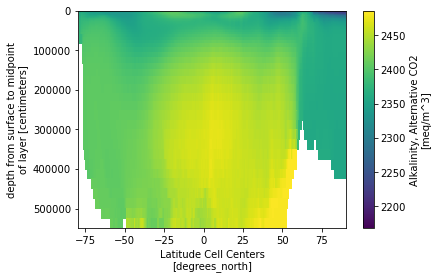

In [16]:
da_zonal_mean['ALK_ALT_CO2'].isel(basins=0).plot(yincrease=False) #zero index of 'basins' is global

In [17]:
lats = da_zonal_mean['ALK_ALT_CO2'].lat_t.values
lats.shape

(394,)

In [18]:
depths = da_zonal_mean['ALK_ALT_CO2'].z_t.values * 0.01
depths.shape

(60,)

In [19]:
alk_diff_global_zonal = da_zonal_mean['ALK_ALT_CO2'].isel(basins=0) - da_zonal_mean['ALK'].isel(basins=0)

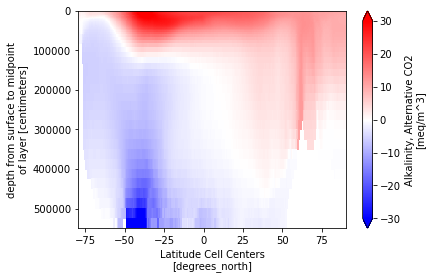

In [20]:
alk_diff_global_zonal.plot(yincrease=False, vmin=-30, vmax=30, cmap='bwr')

In [21]:
global_zonal_pdens = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

In [22]:
global_zonal_pdens

<xarray.DataArray 'PD' (z_t: 60, lat_t: 394)>
array([[      nan,       nan, 26.980347, ..., 25.3844  , 25.371582,
        25.356934],
       [      nan,       nan, 27.049927, ..., 25.465698, 25.453247,
        25.439209],
       [      nan,       nan, 27.09082 , ..., 25.619629, 25.60791 ,
        25.594238],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * lat_t    (lat_t) float32 -79.22052 -78.68631 ... 89.370575 89.904816
  * z_t      (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
Attributes:
    long_name:     Potential Density Ref to Surface
    units:         gram/centimeter^3
    grid_loc:      3111
    cell_methods:  time: mean

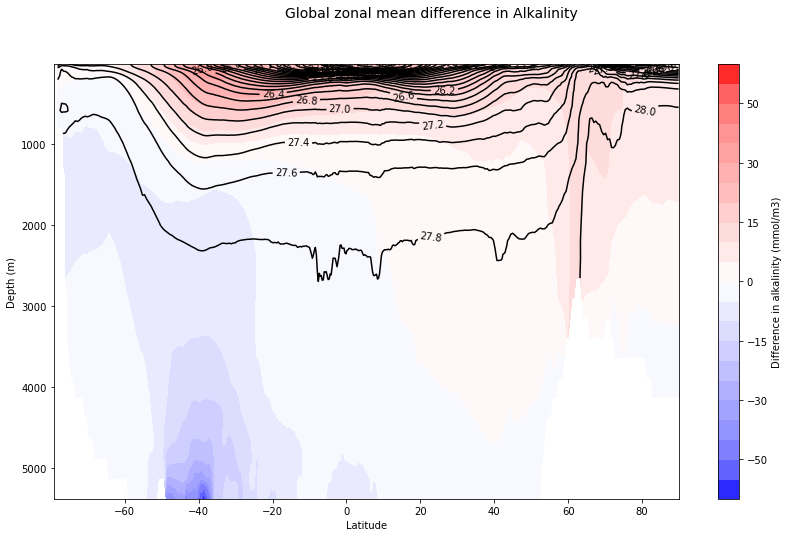

In [23]:
levels = [-90,-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60,90]
sigma_levels = np.arange(21., 29., 0.2)

fig = plt.figure(figsize=(14,8))

plt.suptitle('Global zonal mean difference in Alkalinity', fontsize=14)

ax = fig.add_subplot(1,1,1)
pc=ax.contourf(lats, depths, alk_diff_global_zonal, levels, cmap='bwr')
#contour = plt.contour(lats, depths, alk_diff_global_zonal, levels, colors='k')
contour = plt.contour(lats, depths, global_zonal_pdens, sigma_levels, colors='k')

plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=10)
ax.set(ylabel='Depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()
cbar = fig.colorbar(pc,label='Difference in alkalinity (mmol/m3)')


In [24]:
alk_diff_glb_zonal_top = alk_diff_global_zonal.isel(z_t=slice(0,40))
alk_diff_glb_zonal_bottom = alk_diff_global_zonal.isel(z_t=slice(40,60))
pdens_glb_top = global_zonal_pdens.isel(z_t=slice(0,40))
pdens_glb_bottom = global_zonal_pdens.isel(z_t=slice(40,60))
z_top=depths[0:40]
z_bottom=depths[40:60]

In [25]:
sigma_levels

array([21. , 21.2, 21.4, 21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. ,
       23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2,
       25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4,
       27.6, 27.8, 28. , 28.2, 28.4, 28.6, 28.8])

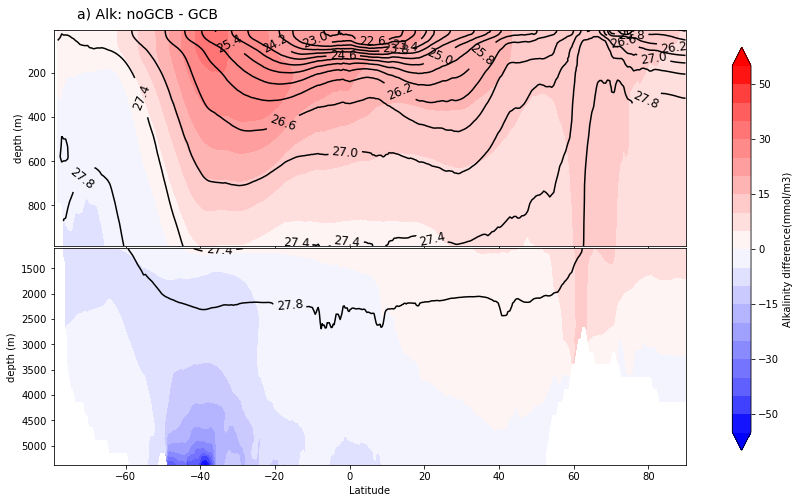

In [26]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(13,8))

plt.suptitle('a) Alk: noGCB - GCB',x=0.15, y=0.92,fontsize=14,ha='left')

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(lats, z_top, alk_diff_glb_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_glb_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, alk_diff_glb_zonal_bottom, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_bottom, pdens_glb_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference(mmol/m3)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/global_zonal2.png', bbox_inches='tight', dpi=600);

In [27]:
pac_zonal_pdens = da_zonal_mean['PD'].isel(basins=1) * 1000. - 1000.

In [28]:
alk_diff_Pac_zonal = da_zonal_mean['ALK_ALT_CO2'].isel(basins=1) - da_zonal_mean['ALK'].isel(basins=1)

In [29]:
alk_diff_pac_zonal_top = alk_diff_Pac_zonal.isel(z_t=slice(0,40))
alk_diff_pac_zonal_bottom = alk_diff_Pac_zonal.isel(z_t=slice(40,60))
pdens_pac_top = pac_zonal_pdens.isel(z_t=slice(0,40))
pdens_pac_bottom = pac_zonal_pdens.isel(z_t=slice(40,60))
z_top=depths[0:40]
z_bottom=depths[40:60]

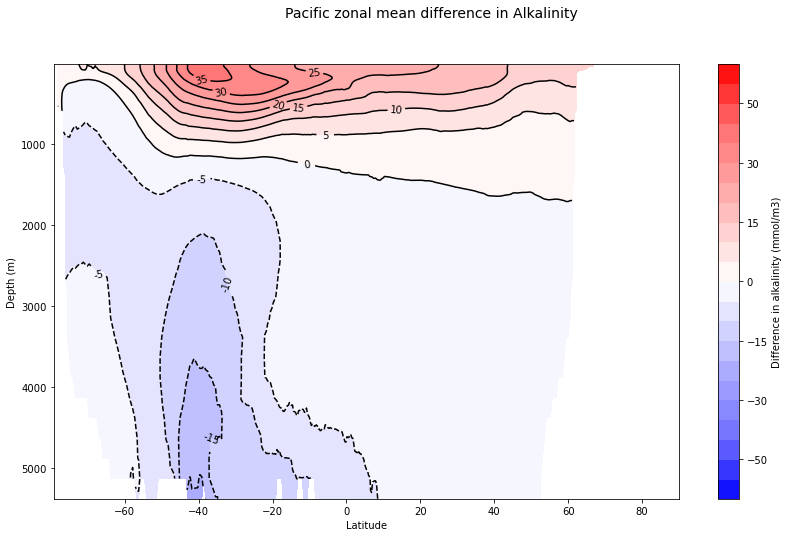

In [30]:
fig = plt.figure(figsize=(14,8))

plt.suptitle('Pacific zonal mean difference in Alkalinity', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(1,1,1)
levels = [-70,-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60,70]
#ax.set_title('Global zonal mean difference in Alkalinity')
pc=ax.contourf(lats, depths, alk_diff_Pac_zonal, levels, cmap='bwr')
contour = plt.contour(lats, depths, alk_diff_Pac_zonal, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='Depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()
cbar = fig.colorbar(pc,label='Difference in alkalinity (mmol/m3)')

#### Pacific basin with sigma lines

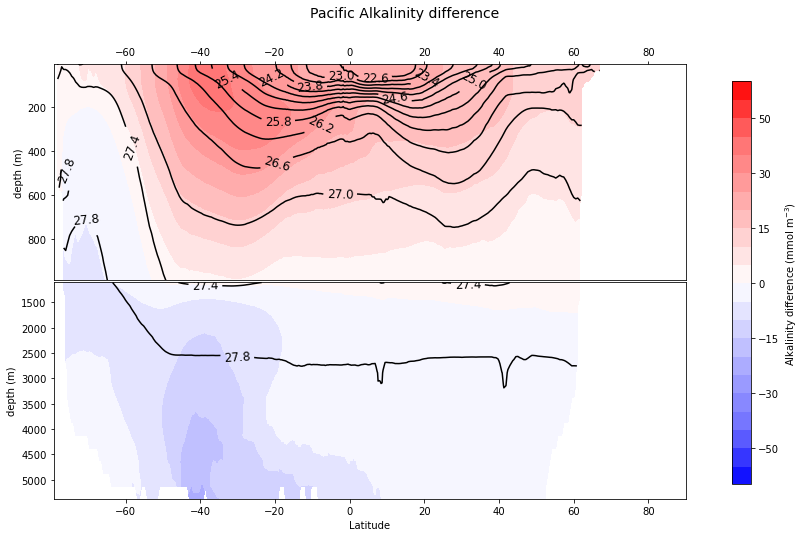

In [31]:
levels = [-70,-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60,70]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(13,8))

plt.suptitle('Pacific Alkalinity difference', fontsize=14)

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(lats, z_top, alk_diff_pac_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_pac_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, alk_diff_pac_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_pac_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/pacific_zonal2.png', bbox_inches='tight', dpi=600);

In [32]:
atl_zonal_pdens = da_zonal_mean['PD'].isel(basins=3) * 1000. - 1000.

In [33]:
alk_diff_Atl_zonal = da_zonal_mean['ALK_ALT_CO2'].isel(basins=3) - da_zonal_mean['ALK'].isel(basins=3)

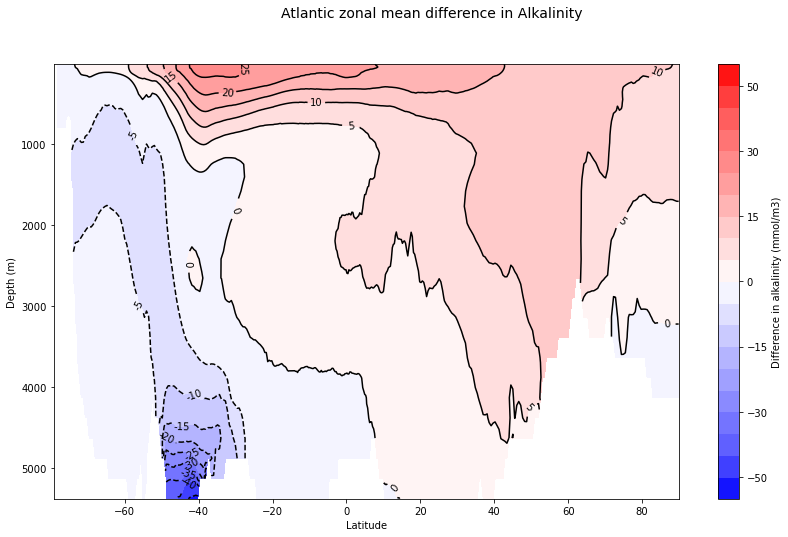

In [34]:
fig = plt.figure(figsize=(14,8))

plt.suptitle('Atlantic zonal mean difference in Alkalinity', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(1,1,1)
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
#ax.set_title('Global zonal mean difference in Alkalinity')
pc=ax.contourf(lats, depths, alk_diff_Atl_zonal, levels, cmap='bwr')
contour = plt.contour(lats, depths, alk_diff_Atl_zonal, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='Depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()
cbar = fig.colorbar(pc,label='Difference in alkalinity (mmol/m3)')

In [35]:
alk_diff_atl_zonal_top = alk_diff_Atl_zonal.isel(z_t=slice(0,40))
alk_diff_atl_zonal_bottom = alk_diff_Atl_zonal.isel(z_t=slice(40,60))
pdens_atl_top = atl_zonal_pdens.isel(z_t=slice(0,40))
pdens_atl_bottom = atl_zonal_pdens.isel(z_t=slice(40,60))
z_top=depths[0:40]
z_bottom=depths[40:60]

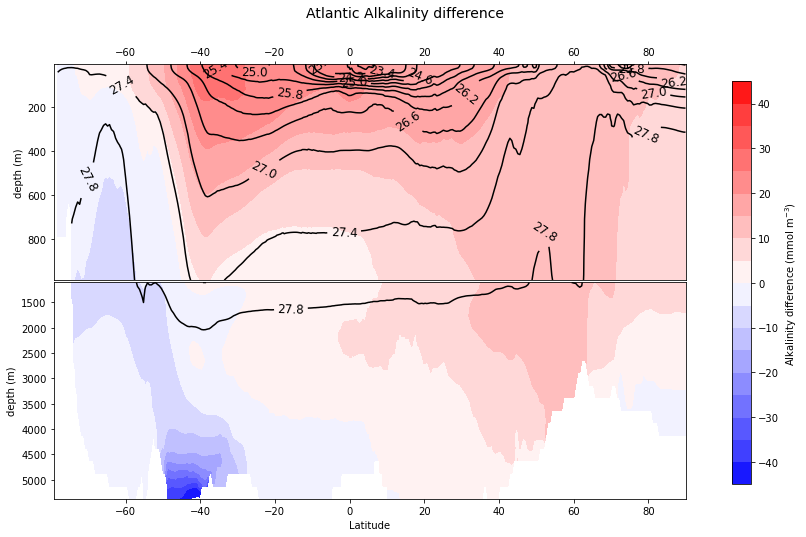

In [36]:
levels = [-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(13,8))

plt.suptitle('Atlantic Alkalinity difference', fontsize=14)

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(lats, z_top, alk_diff_atl_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_atl_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, alk_diff_atl_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_atl_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/atlantic_zonal2.png', bbox_inches='tight', dpi=600);

## Indian basin

In [37]:
ind_zonal_pdens = da_zonal_mean['PD'].isel(basins=2)  * 1000. - 1000.

In [38]:
alk_diff_Ind_zonal = da_zonal_mean['ALK_ALT_CO2'].isel(basins=2) - da_zonal_mean['ALK'].isel(basins=2)

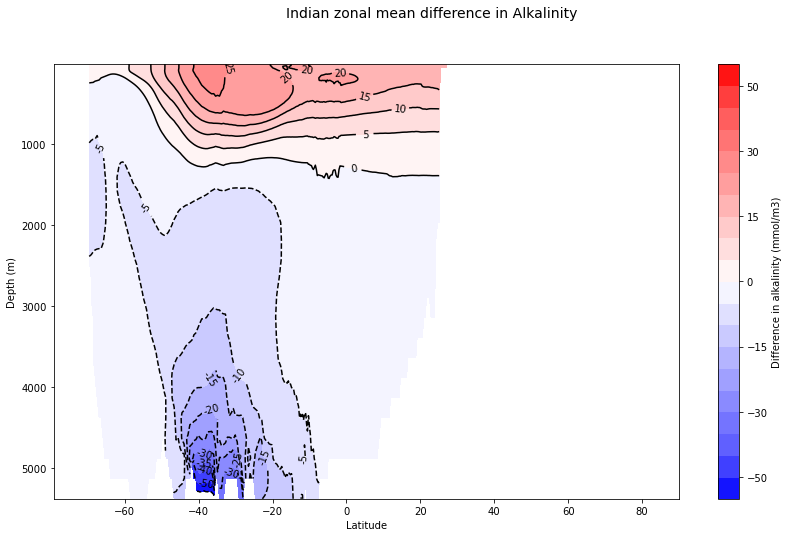

In [39]:
fig = plt.figure(figsize=(14,8))

plt.suptitle('Indian zonal mean difference in Alkalinity', fontsize=14)

#ROW 1  - PO4 CESM

ax = fig.add_subplot(1,1,1)
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
#ax.set_title('Global zonal mean difference in Alkalinity')
pc=ax.contourf(lats, depths, alk_diff_Ind_zonal, levels, cmap='bwr')
contour = plt.contour(lats, depths, alk_diff_Ind_zonal, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax.set(ylabel='Depth (m)',xlabel='Latitude') #, xlabel='time (simulation years)')
ax.invert_yaxis()
cbar = fig.colorbar(pc,label='Difference in alkalinity (mmol/m3)')

In [40]:
alk_diff_ind_zonal_top = alk_diff_Ind_zonal.isel(z_t=slice(0,40))
alk_diff_ind_zonal_bottom = alk_diff_Ind_zonal.isel(z_t=slice(40,60))
pdens_ind_top = ind_zonal_pdens.isel(z_t=slice(0,40))
pdens_ind_bottom = ind_zonal_pdens.isel(z_t=slice(40,60))
z_top=depths[0:40]
z_bottom=depths[40:60]

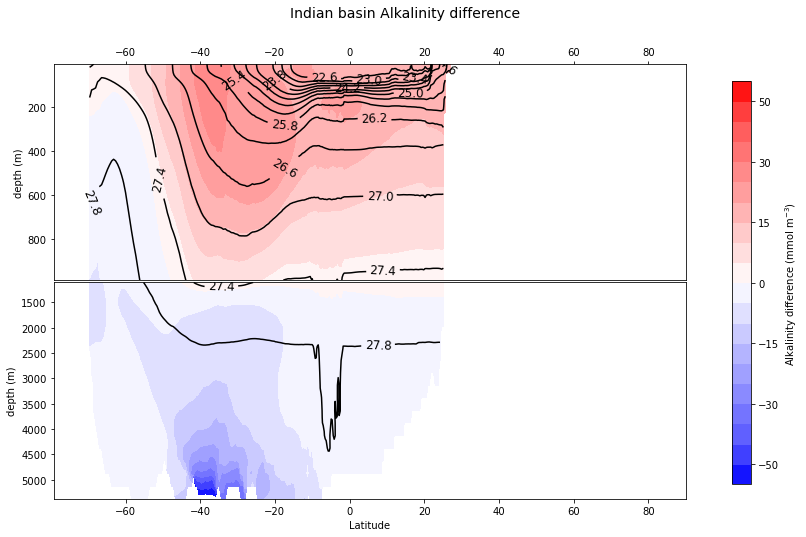

In [41]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(13,8))

plt.suptitle('Indian basin Alkalinity difference', fontsize=14)

ax = fig.add_subplot(2,1,1)

pc=ax.contourf(lats, z_top, alk_diff_ind_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_ind_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, alk_diff_ind_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_ind_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/indian_zonal2.png', bbox_inches='tight', dpi=600);

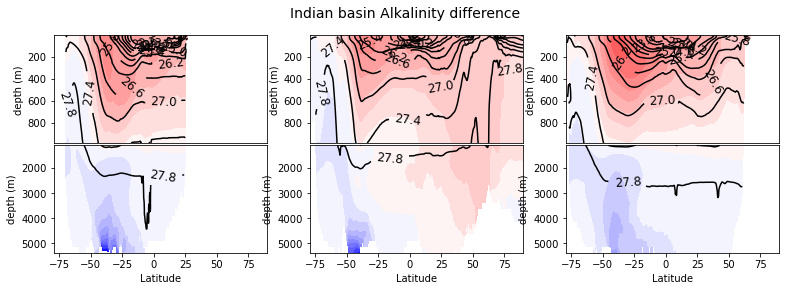

In [42]:
levels = [-60,-50,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

fig = plt.figure(figsize=(13,4))

#INDIAN
plt.suptitle('Indian basin Alkalinity difference', fontsize=14)
ax = fig.add_subplot(2,3,1)
pc=ax.contourf(lats, z_top, alk_diff_ind_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_ind_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax = fig.add_subplot(2,3,4)
pc=ax.contourf(lats, z_bottom, alk_diff_ind_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_ind_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()
fig.subplots_adjust(hspace=0.04)




#ATLANTIC
ax = fig.add_subplot(2,3,2)

pc=ax.contourf(lats, z_top, alk_diff_atl_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_atl_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax = fig.add_subplot(2,3,5)
pc=ax.contourf(lats, z_bottom, alk_diff_atl_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_atl_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()
fig.subplots_adjust(hspace=0.02)



#PACIFIC
ax = fig.add_subplot(2,3,3)

pc=ax.contourf(lats, z_top, alk_diff_pac_zonal_top, levels, cmap='bwr',extend='both')
contour = plt.contour(lats, z_top, pdens_pac_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax = fig.add_subplot(2,3,6)
pc=ax.contourf(lats, z_bottom, alk_diff_pac_zonal_bottom, levels, cmap='bwr')
contour = plt.contour(lats, z_bottom, pdens_pac_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()
fig.subplots_adjust(hspace=0.02)








#fig.subplots_adjust(sharey='row')   #right=0.8,hspace=0.01)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (mmol m$^{-3}$)')
#fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/indian_zonal2.png', bbox_inches='tight', dpi=600);

In [43]:
sigma_levels = [23., 23.8, 24.6,  25.4, 26.2, 26.6, 27., 27.4, 27.8, 28.2]

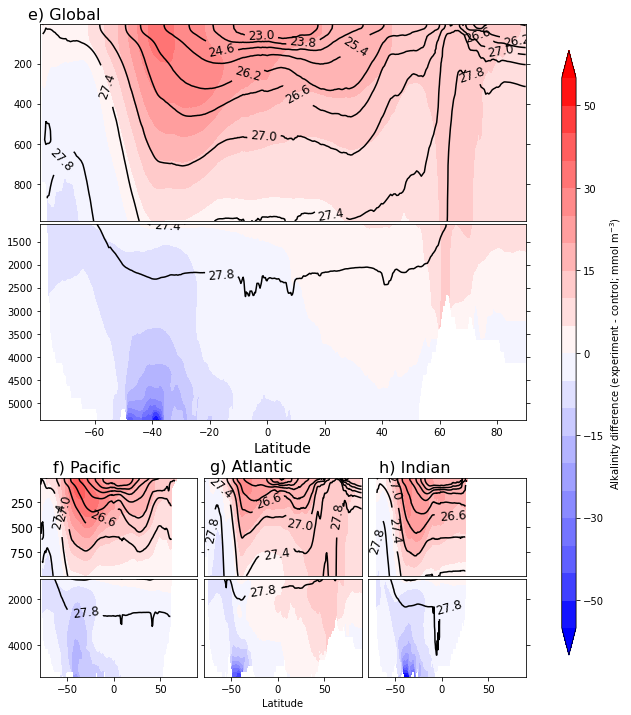

In [45]:
fig, ax = plt.subplots(nrows=5,ncols=3, figsize=(10,12), gridspec_kw={'height_ratios':[6,6,1.6,3,3]},sharey='row')
gs = ax[0,1].get_gridspec()
for a in ax[:3,:].flat:
    a.remove()
    
glob_top = fig.add_subplot(gs[0,:])
glob_bottom = fig.add_subplot(gs[1,:])
pac_top = ax[3,0]
pac_bottom = ax[4,0]
atl_top = ax[3,1]
atl_bottom = ax [4,1]
ind_top = ax[3,2]
ind_bottom = ax[4,2]

#GLOBAL TOP
pc=glob_top.contourf(lats, z_top, alk_diff_glb_zonal_top, levels, cmap='bwr',extend='both')
contour = glob_top.contour(lats, z_top, pdens_glb_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
#glob_top.set(ylabel='Depth (m)') #, xlabel='time (simulation years)')
glob_top.invert_yaxis()
glob_top.tick_params(bottom=False,labelbottom=False)
glob_top.set_title('e) Global',x=0.05, y=1,fontsize=16)

glob_top.tick_params(right=True,labelright=False)
#GLOBAL BOTTOM
pc=glob_bottom.contourf(lats, z_bottom, alk_diff_glb_zonal_bottom, levels, cmap='bwr',extend='both')
contour = glob_bottom.contour(lats, z_bottom, pdens_glb_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
glob_bottom.set(xlabel='Latitude') #, xlabel='time (simulation years)')
glob_bottom.invert_yaxis()
glob_bottom.tick_params(right=True,labelright=False)


#redefine sigma levels for the bottom plots
sigma_levels1 = [26.6, 27., 27.4, 27.8, 28.2]
sigma_levels2 = [23., 23.8, 24.6,  25.4, 26.2]




#Pacific TOP
pc=pac_top.contourf(lats, z_top, alk_diff_pac_zonal_top, levels, cmap='bwr',extend='both')
contour = pac_top.contour(lats, z_top, pdens_pac_top, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour = pac_top.contour(lats, z_top, pdens_pac_top, sigma_levels2, colors='k')
pac_top.invert_yaxis()
pac_top.tick_params(bottom=False,labelbottom=False,labelsize=12)
pac_top.set_title('f) Pacific',x=0.3, y=1,fontsize=16)

#PACIFIC BOTTOM
pc=pac_bottom.contourf(lats, z_bottom, alk_diff_pac_zonal_bottom, levels, cmap='bwr',extend='both')
contour = pac_bottom.contour(lats, z_bottom, pdens_pac_bottom, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour = pac_bottom.contour(lats, z_bottom, pdens_pac_bottom, sigma_levels2, colors='k')
plt.xlabel('Latitude', fontsize=14)
#plt.ylabel('Depth (m)', fontsize=14) #, xlabel='time (simulation years)')
pac_bottom.invert_yaxis()


#Atlantic TOP
pc=atl_top.contourf(lats, z_top, alk_diff_atl_zonal_top, levels, cmap='bwr',extend='both')
contour = atl_top.contour(lats, z_top, pdens_atl_top, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour = atl_top.contour(lats, z_top, pdens_atl_top, sigma_levels2, colors='k')
atl_top.tick_params(axis='x',bottom=False,labelbottom=False)
atl_top.tick_params(axis='y',bottom=False,labelbottom=False)
atl_top.set_title('g) Atlantic',x=0.3, y=1,fontsize=16)


#Atlantic BOTTOM
pc=atl_bottom.contourf(lats, z_bottom, alk_diff_atl_zonal_bottom, levels, cmap='bwr',extend='both')
contour = atl_bottom.contour(lats, z_bottom, pdens_atl_bottom, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour = atl_bottom.contour(lats, z_bottom, pdens_atl_bottom, sigma_levels2, colors='k')
atl_bottom.tick_params(axis='y',bottom=False,labelbottom=False)
atl_bottom.set(xlabel='Latitude') #, xlabel='time (simulation years)')




#Indian TOP
pc=ind_top.contourf(lats, z_top, alk_diff_ind_zonal_top, levels, cmap='bwr',extend='both')
contour = ind_top.contour(lats, z_top, pdens_ind_top, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
contour = ind_top.contour(lats, z_top, pdens_ind_top, sigma_levels2, colors='k')
ind_top.yaxis.tick_right()
ind_top.tick_params(axis='x',bottom=False,labelbottom=False)
ind_top.tick_params(axis='y',bottom=False,labelbottom=False)
ind_top.set_title('h) Indian',x=0.3, y=1,fontsize=16)


#Indian BOTTOM
pc=ind_bottom.contourf(lats, z_bottom, alk_diff_ind_zonal_bottom, levels, cmap='bwr',extend='both')
contour = ind_bottom.contour(lats, z_bottom, pdens_ind_bottom, sigma_levels1, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12) 
contour = ind_bottom.contour(lats, z_bottom, pdens_ind_bottom, sigma_levels2, colors='k')
ind_bottom.yaxis.tick_right()
#ind_bottom.tick_params(axis='x',bottom=False,labelbottom=False)
#ind_bottom.set(xlabel='Latitude') #, xlabel='time (simulation years)')

plt.subplots_adjust(right=0.8,hspace=0.02,wspace=0.04)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Alkalinity difference (experiment - control; mmol m$^{-3}$)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/zonal_100m_DLSpdf', bbox_inches='tight',format='pdf');

